## Caracal example notebook 2

This notebook demonstrates the sklearn plotting function.

In [1]:
import pandas as pd
import numpy as np
import caracal as cr
from caracal import ModelConfig, ScikitLearnModelWrapper, TabularDataHandler
# the new sklearn-specific plotting function
from caracal.plotting import plot_variability_summary
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tempfile
import os

2025-11-17 22:10:51.301010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 22:10:51.332022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 22:10:51.800394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as noteboo

In [2]:
# Load and prepare iris dataset
print("\n1. Loading Iris Dataset...")
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

print(f"   Dataset shape: {iris_df.shape}")
print(f"   Classes: {list(iris.target_names)}")
print(f"   Class distribution:")
for i, name in enumerate(iris.target_names):
    count = sum(iris.target == i)
    print(f"     {name}: {count} samples")

# Save to temporary CSV for TabularDataHandler
temp_dir = tempfile.mkdtemp()
iris_path = os.path.join(temp_dir, 'iris.csv')
iris_df.to_csv(iris_path, index=False)

# Create data handler
data_handler = TabularDataHandler(
    data_path=iris_path,
    target_column='target'
)



1. Loading Iris Dataset...
   Dataset shape: (150, 5)
   Classes: ['setosa', 'versicolor', 'virginica']
   Class distribution:
     setosa: 50 samples
     versicolor: 50 samples
     virginica: 50 samples



2. Running Random Forest Variability Study...
Enabled GPU memory growth
Loading and preparing data...
Loaded tabular data: 150 rows, 5 columns
Target column: target
Feature columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Data loaded successfully

Starting Variability Study
  Runs: 8
  Epochs per run: 10
  Execution mode: in standard mode

 - Run 1: Training...
 - Run 1: Completed successfully


2025-11-17 22:10:57.369017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 22:10:57.428872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 22:10:57.430714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 - Run 2: Training...
 - Run 2: Completed successfully
 - Run 3: Training...
 - Run 3: Completed successfully
 - Run 4: Training...
 - Run 4: Completed successfully
 - Run 5: Training...
 - Run 5: Completed successfully
 - Run 6: Training...
 - Run 6: Completed successfully
 - Run 7: Training...
 - Run 7: Completed successfully
 - Run 8: Training...
 - Run 8: Completed successfully
--------------------------------------------------

Study Summary:
  Successful runs: 8/8
  Val accuracy: 0.8917 ± 0.0323

Random Forest Results:
Variability Study Results
Successful runs: 8
Final validation accuracy:
  Mean: 0.8917
  Std:  0.0323
  Min:  0.8667
  Max:  0.9333

Detailed Analysis:
Random Forest accuracies: ['0.933', '0.867', '0.867', '0.867', '0.867', '0.933', '0.933', '0.867']
  Mean: 0.8917 ± 0.0323
  Range: [0.867, 0.933]
  Coefficient of Variation: 3.6%

3. Testing sklearn-Specific Plotting Functions...
   Creating variability summary plot...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


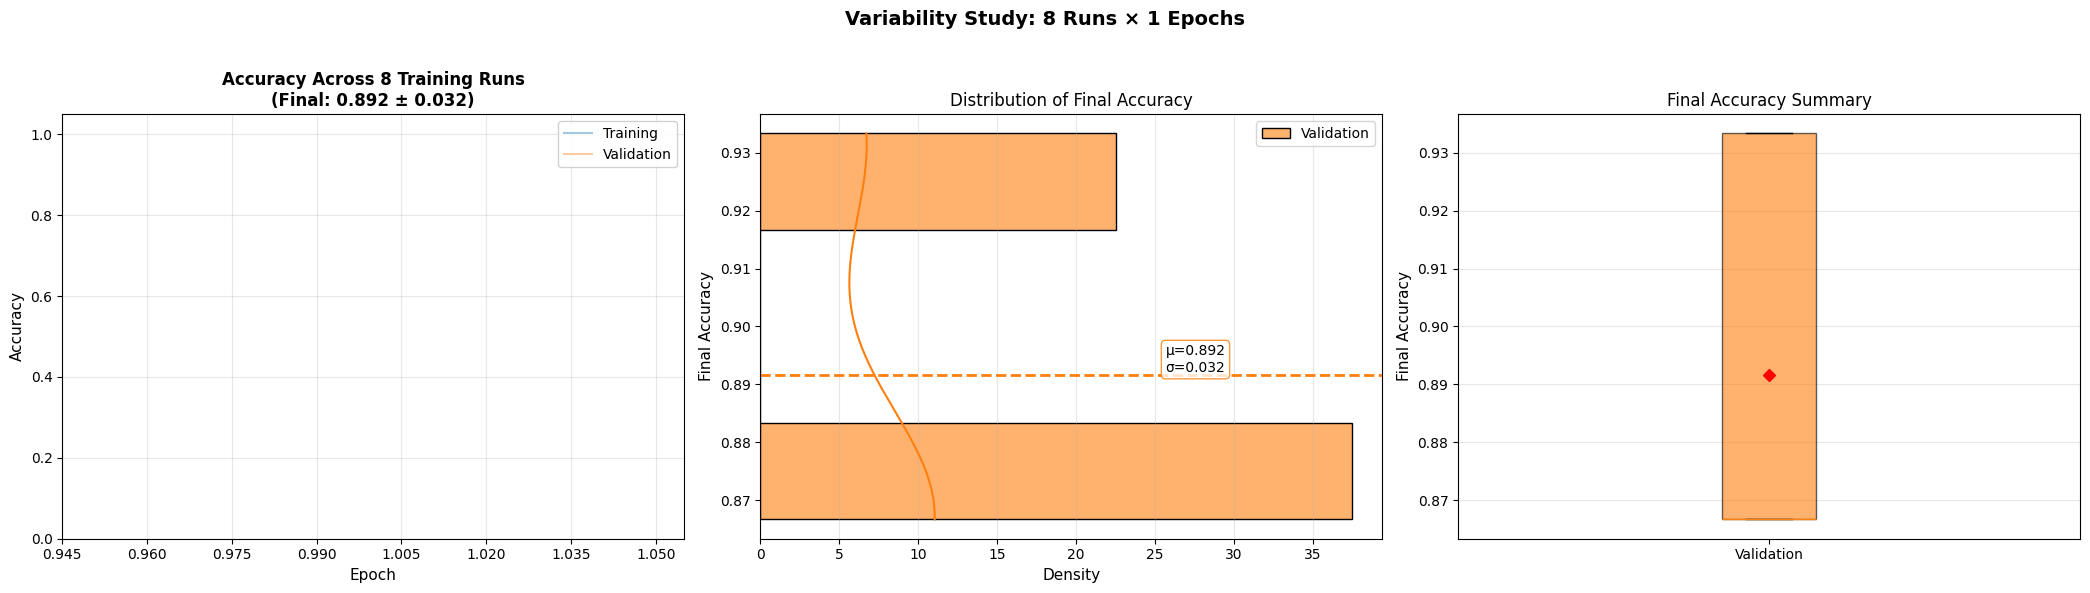

   sklearn plotting completed successfully!

4. Testing Statistical Analysis...
   Statistical analysis failed: StatisticalTestResult.__init__() missing 2 required positional arguments: 'statistic' and 'p_value'

5. Testing Enhanced Results Object...
   Available metrics: ['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss']
   Results DataFrame: (8, 6)
   Sample of results:
 run_id  final_val_accuracy
      1            0.933333
      2            0.866667
      3            0.866667
   Enhanced results object working correctly!

6. Cleanup...
   Temporary files cleaned up successfully

SKLEARN TEST COMPLETED!
Random Forest Performance: 0.8917 ± 0.0323
Framework Status: ✓ sklearn models working with appropriate visualization


In [3]:
# Model builder with variability (different random seeds)
def create_random_forest_with_variability(config):
    """Create Random Forest with different random seed each run."""
    global _run_counter
    _run_counter += 1
    
    base_seed = config.get('base_seed', 42)
    current_seed = base_seed + _run_counter
    
    rf = RandomForestClassifier(
        n_estimators=config.get('n_estimators', 100),
        max_depth=config.get('max_depth', None),
        min_samples_split=config.get('min_samples_split', 2),
        min_samples_leaf=config.get('min_samples_leaf', 1),
        random_state=current_seed,
        bootstrap=True
    )
    
    return ScikitLearnModelWrapper(rf, model_id=f"random_forest_run_{_run_counter}")

# Test configuration
rf_config = ModelConfig({
    'n_estimators': 50,
    'max_depth': 4,
    'min_samples_split': 5,
    'base_seed': 42
})

print(f"\n2. Running Random Forest Variability Study...")
_run_counter = 0  # Reset counter

rf_results = cr.run_variability_study(
    model_builder=create_random_forest_with_variability,
    data_handler=data_handler,
    model_config=rf_config,
    num_runs=8,  # Reasonable number for testing
    epochs_per_run=None
)

print(f"\nRandom Forest Results:")
print(rf_results.summarize())

# Extract and analyze results
rf_accuracies = rf_results.get_final_metrics('val_accuracy')
rf_values = list(rf_accuracies.values())

print(f"\nDetailed Analysis:")
print(f"Random Forest accuracies: {[f'{v:.3f}' for v in rf_values]}")
print(f"  Mean: {np.mean(rf_values):.4f} SD: {np.std(rf_values):.4f}")
print(f"  Range: [{np.min(rf_values):.3f}, {np.max(rf_values):.3f}]")
print(f"  Coefficient of Variation: {np.std(rf_values)/np.mean(rf_values)*100:.1f}%")

# Test the new sklearn-specific plotting functionality
print(f"\n3. Testing sklearn-Specific Plotting Functions...")

try:
    print("   Creating variability summary plot...")
    plot_variability_summary(
        all_runs_metrics_list=rf_results.all_runs_metrics,
        final_metrics_series=rf_results.final_val_accuracies,
        metric='accuracy',
        show_histogram=True, 
        show_boxplot=True
    )
    
    print("   sklearn plotting completed successfully!")
    
except Exception as e:
    print(f"   sklearn plotting failed: {e}")
    import traceback
    traceback.print_exc()

# Test statistical analysis if available
print(f"\n4. Testing Statistical Analysis...")

try:
    from caracal.analysis import mann_whitney_test, shapiro_wilk_test
    
    # Test normality of results
    rf_series = pd.Series(rf_values, name='Random Forest Accuracy')
    
    normality_result = shapiro_wilk_test(rf_series)
    print(f"   Normality Test (Shapiro-Wilk):")
    print(f"     W statistic: {normality_result.statistic:.4f}")
    print(f"     P-value: {normality_result.p_value:.4f}")
    print(f"     Normal distribution: {'Yes' if not normality_result.is_significant() else 'No'}")
    
    # Test if results are significantly different from 90% accuracy
    high_performance = pd.Series([0.9] * len(rf_values), name='90% Benchmark')
    
    benchmark_test = mann_whitney_test(rf_series, high_performance)
    print(f"\n   Benchmark Comparison (vs 90% accuracy):")
    print(f"     Mann-Whitney U: {benchmark_test.statistic:.3f}")
    print(f"     P-value: {benchmark_test.p_value:.4f}")
    print(f"     Effect size: {benchmark_test.effect_size:.3f} ({benchmark_test.effect_size_interpretation})")
    print(f"     Conclusion: {benchmark_test.conclusion}")
    
    print(f"   Statistical analysis completed successfully!")
    
except ImportError:
    print(f"   Statistical analysis not available (missing scipy)")
except Exception as e:
    print(f"   Statistical analysis failed: {e}")

# Test enhanced results object methods
print(f"\n5. Testing Enhanced Results Object...")

try:
    available_metrics = rf_results.get_available_metrics()
    print(f"   Available metrics: {available_metrics}")
    
    # Test DataFrame conversion
    results_df = rf_results.to_dataframe()
    print(f"   Results DataFrame: {results_df.shape}")
    print(f"   Sample of results:")
    print(results_df[['run_id', 'final_val_accuracy']].head(3).to_string(index=False))
    
    print(f"   Enhanced results object working correctly!")
    
except Exception as e:
    print(f"   Enhanced results object failed: {e}")

# Cleanup
print(f"\n6. Cleanup...")
try:
    os.unlink(iris_path)
    os.rmdir(temp_dir)
    print(f"   Temporary files cleaned up successfully")
except Exception as e:
    print(f"   Cleanup warning: {e}")

print(f"\n" + "="*60)
print(f"SKLEARN TEST COMPLETED!")
print(f"Random Forest Performance: {np.mean(rf_values):.4f} ± {np.std(rf_values):.4f}")
print(f"Framework Status: ✓ sklearn models working with appropriate visualization")
print(f"=" * 60)